In [ ]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import models.loadImg as loadImg
import models.modelsCNN as modelsCNN
import models.optimizer as optimizer

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io
import umap
from sklearn.cluster import MiniBatchKMeans,AgglomerativeClustering
from sklearn.decomposition import PCA

In [2]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "0,1,2,3" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3" 
use_cuda=True


In [3]:
radius=48
datadir='/media/xinyi/dcis2idc/data'
sampleList=[]
for s in os.listdir('/media/xinyi/dcis2idc/data'):
    if 'hoechst'  in s and ('_1_' in s or '_3_' in s or '_4_' in s or '_6_' in s):
#     if 'hoechst'  in s and ('_3_' in s or '_4_' in s or '_6_' in s):
        sampleList.append(s)
print(sampleList)
trainingCores={'br1003a':[],'br8018a':[],'br301':[]}
for s in range(1,11):
# for s in range(5,11):
    trainingCores['br1003a'].append('A'+str(s))
    trainingCores['br1003a'].append('C'+str(s))
    trainingCores['br1003a'].append('I'+str(s))
for s in range(1,11):
    if s<9:
        trainingCores['br8018a'].append('H'+str(s))
    trainingCores['br8018a'].append('A'+str(s))
    trainingCores['br8018a'].append('B'+str(s))
    trainingCores['br8018a'].append('F'+str(s))
for s in range(1,7):
    for sr in ['A','B','C','D','E']:
        trainingCores['br301'].append(sr+str(s))

['br1003a_1_cytokeratin_555_aSMA_647_hoechst', 'br1003a_3_collagen1_647_hoechst', 'br1003a_4_cytokeratin_555_gh2ax_647_hoechst', 'br301_4_cytokeratin_555_aSMA_647_hoechst', 'br301_6_collagen1_647_hoechst', 'br8018a_1_cytokeratin_555_aSMA_647_hoechst', 'br8018a_3_collagen1_647_hoechst', 'br8018a_4_cytokeratin_555_gh2ax_647_hoechst']


In [21]:
datadir='/media/xinyi/dcis2idc/data'
with open(os.path.join(datadir,'processed','train_cnnvae'), 'rb') as input:
    allImg=pickle.load(input)
with open(os.path.join(datadir,'processed','train_cnnvae_trainIdx'), 'rb') as input:
    trainIdx=pickle.load(input)
with open(os.path.join(datadir,'processed','train_cnnvae_valIdx'), 'rb') as input:
    valIdx=pickle.load(input)
with open(os.path.join(datadir,'processed','train_cnnvae_testIdx'), 'rb') as input:
    testIdx=pickle.load(input)

In [10]:
#VAE settings
seed=3
epochs=10000
saveFreq=2000
lr=0.00001 #initial learning rate
weight_decay=0 #Weight for L2 loss on embedding matrix.

# batchsize=4
batchsize=8000
kernel_size=4
stride=2
padding=1

# fc_dim1=6000
hidden1=64 #Number of channels in hidden layer 1
hidden2=128 
hidden3=256
hidden4=256
hidden5=96
fc_dim1=96*3*3
fc_dim2=6000

dropout=0.01
kl_weight=0.0000001
model_str='cnn_vae'



In [4]:
name='exp0'
logsavepath='/media/xinyi/dcis2idc/log/cnnvae'+name
modelsavepath='/media/xinyi/dcis2idc/models/cnnvae'+name
plotsavepath='/media/xinyi/dcis2idc/plots/cnnvae'+name


if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

In [23]:
# Set cuda and seed
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.enabled = True
    
loss_match=torch.nn.MSELoss()
# Create model
if model_str=='cnn_vae':
    modelcnn = modelsCNN.CNN_VAE(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
    loss_kl=optimizer.optimizer_kl
    loss_x=torch.nn.MSELoss()
if model_str=='cnn_vae_sharded':
    modelcnn = modelsCNN.CNN_VAE_sharded(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
    loss_kl=optimizer.optimizer_kl
    loss_x=torch.nn.MSELoss()
    use_cuda=False

if model_str=='cnn_vae_alexnet':
    modelcnn = modelsCNN.CNN_VAE_alexnet(fc_dim1)
    loss_kl=optimizer.optimizer_kl
    loss_x=torch.nn.MSELoss(reduction='sum')

    
modelcnn.cuda()       
optimizerCNN = optim.Adam(modelcnn.parameters(), lr=lr, weight_decay=weight_decay)

In [5]:
ep=311

In [24]:
#compute latent

use_cuda=True
modelcnn.load_state_dict(torch.load(os.path.join(modelsavepath,str(ep)+'.pt')))
latent=np.zeros((allImg.shape[0],fc_dim2))
with torch.no_grad():
    modelcnn.cuda()
    modelcnn.eval()
    nplotBatches=int(np.ceil(allImg.shape[0]/batchsize))
    for i in range(nplotBatches):
        plotInput=torch.tensor(allImg[i*batchsize:min((i+1)*batchsize,allImg.shape[0])])
        if use_cuda:
            plotInput=plotInput.cuda().float()
        recon,z, mu, logvar = modelcnn(plotInput)
        latent[i*batchsize:min((i+1)*batchsize,allImg.shape[0])]=mu.cpu().detach().numpy()


In [6]:
#umap
# np.random.seed(3)
# plotPCT=0.1
# plottingIdx=np.array([])
# for s in np.unique(allImgNames):
#     nsamples=int(np.sum(allImgNames==s)*plotPCT)
#     plottingIdx=np.concatenate((plottingIdx,
#                                 np.random.choice(np.arange(allImgNames.shape[0])[allImgNames==s],nsamples,replace=False)))
n_neighbors=10
min_dist=0.25

# reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed).fit(latent[plottingIdx.astype(int)])
savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(ep)

In [11]:
# with open(os.path.join(modelsavepath,'umap'+savenameAdd), 'rb') as output:
#     reducer=pickle.load(output)

In [7]:
with open(os.path.join(datadir,'processed','train_cnnvae_names'), 'rb') as input:
    allImgNames=pickle.load(input)
with open(os.path.join(modelsavepath,'umap'+savenameAdd+'_plottingIdx'), 'rb') as input:
    plottingIdx=pickle.load(input)

In [36]:
np.random.seed(seed)
def plotembeddingbyCT(ctlist,savename,excludelist,embedding,savepath,plotname,plotdimx=0,plotdimy=1,savenameAdd='',img=None,ncolors=None):
    
    celltypes=np.unique(ctlist)
    if ncolors is None:
        colortest=sns.color_palette("husl", celltypes.size)
    else:
        colortest=sns.color_palette("husl", ncolors)
    fig, ax = plt.subplots(dpi=400)
    if not img is None:
        plt.imshow(img)
    for ct in celltypes:
        if ct in excludelist:
            continue
        idx=(ctlist==ct)
        if not img is None:
            ax.scatter(
                embedding[idx, plotdimy],
                embedding[idx, plotdimx],
#                 color=colortest[celltypes_dict[ct]],label=ct,s=1.5,alpha=0.5
                color=colortest[int(ct)],label=ct,s=1.5,alpha=0.5
                )
        else:
            ax.scatter(
                embedding[idx, plotdimx],
                embedding[idx, plotdimy],
#                 color=colortest[celltypes_dict[ct]],label=ct,s=1.5,alpha=0.5
                color=colortest[int(ct)],label=ct,s=2.5,alpha=1
                )

    plt.gca().set_aspect('equal', 'datalim')
    fig.set_figheight(5)
    fig.set_figwidth(5)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    # Put a legend below current axis
#     ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#               fancybox=True, shadow=True, ncol=2,prop={'size': 6})
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True,ncol=5, shadow=True,prop={'size': 6})
#     ax.legend(ncol=3)
    plt.title(plotname+' embedding', fontsize=12)
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'.jpg'))
#     plt.show()
    
#     fig.clf()
    plt.close('all')
    
    gc.collect()
    
def plotembeddingbyCT_str(ctlist,savename,excludelist,embedding,savepath,plotname,plotdimx=0,plotdimy=1,savenameAdd=''):
    celltypes=np.unique(ctlist)
    celltypes_dict={}
    idx=0
    for ct in celltypes:
        celltypes_dict[ct]=idx
        idx+=1
        
    colortest=sns.color_palette("husl", celltypes.size)
#     colortest=sns.color_palette("husl", 4)
#     np.random.shuffle(colortest)
    fig, ax = plt.subplots(dpi=400)
    for ct in celltypes:
        if ct in excludelist:
            continue
        idx=(ctlist==ct)
        ax.scatter(
            embedding[idx, plotdimx],
            embedding[idx, plotdimy],
            color=colortest[celltypes_dict[ct]],label=ct,s=1.5,alpha=0.5
#             color=colortest[int(ct)],label=ct,s=1.5,alpha=0.5
            )

    plt.gca().set_aspect('equal', 'datalim')
    fig.set_figheight(5)
    fig.set_figwidth(5)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True,ncol=2, shadow=True,prop={'size': 6})
#     ax.legend(ncol=3)
    plt.title(plotname+' embedding', fontsize=24)
#     plt.tight_layout()
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'.jpg'))
#     plt.show()
    
#     fig.clf()
    plt.close('all')
    
    gc.collect()
    
np.random.seed(seed)
def plotembeddingbyCT_contrast(ctlist,savename,excludelist,embedding,savepath,plotname,plotdimx=0,plotdimy=1,savenameAdd='',maxplot=None): 
    celltypes=np.unique(ctlist)
    celltypes_dict={}
    idx=0
    for ct in celltypes:
        celltypes_dict[ct]=idx
        idx+=1

    colortest=sns.color_palette("tab10")
    if not os.path.exists(os.path.join(savepath)):
        os.makedirs(savepath)

    for ct in celltypes:
        if maxplot and int(ct)>maxplot:
            continue
        fig, ax = plt.subplots()
        if ct == 'Unassigned':
            continue

        idx=(ctlist!=ct)
        ax.scatter(
            embedding[idx, plotdimx],
            embedding[idx, plotdimy],
            color=colortest[1],label='others',s=1,alpha=0.5
            )

        idx=(ctlist==ct)
        ax.scatter(
            embedding[idx, plotdimx],
            embedding[idx, plotdimy],
            color=colortest[0],label=ct,s=3,alpha=0.5
            )

        plt.gca().set_aspect('equal', 'datalim')
        fig.set_figheight(10)
        fig.set_figwidth(10)
        ax.legend()
#         plt.title(plotname+' embedding', fontsize=24)
        plt.gcf().savefig(os.path.join(savepath,savename+'_'+str(ct)+savenameAdd+'.jpg'))
#         plt.show()
#         nplot+=1
        
    
#         fig.clf()
        plt.close('all')
        gc.collect()

In [9]:
plottype='umap'
sampledir=plotsavepath
savedir=os.path.join(sampledir,'embedding_'+plottype)
clustersavedir=os.path.join(sampledir,'cluster')
if not os.path.exists(sampledir):
    os.mkdir(sampledir)
if not os.path.exists(savedir):
    os.mkdir(savedir)
if not os.path.exists(clustersavedir):
    os.mkdir(clustersavedir)

In [12]:
dim1=0
dim2=1
# plotembeddingbyCT(allImgNames[plottingIdx.astype(int)],'sample_umaptrain',[],reducer.embedding_,savedir,plottype+' of all samples',plotdimx=dim1,plotdimy=dim2,savenameAdd=savenameAdd+'_pc'+str(dim1)+'pc'+str(dim2),ncol=2)


In [13]:
#plot by disease progression
br1003aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR1003a specs.xlsx',header=10)
br301Specs=pd.read_excel('/media/xinyi/dcis2idc/data/BR301 specs.xlsx',header=10)
br8018aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR8018a specs.xlsx',header=10)
br1003aSpecs.index=br1003aSpecs.loc[:,'Position']
br301Specs.index=br301Specs.loc[:,'Position']
br8018aSpecs.index=br8018aSpecs.loc[:,'Position']

In [ ]:
progList=np.copy(allImgNames)
for s in np.unique(allImgNames):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList[allImgNames==s]=prog_s

In [18]:
# plotembeddingbyCT(progList[plottingIdx.astype(int)],'prog_umaptrain',[],reducer.embedding_,savedir,plottype+' of all samples',plotdimx=dim1,plotdimy=dim2,savenameAdd=savenameAdd+'_pc'+str(dim1)+'pc'+str(dim2),ncol=2)
# plotembeddingbyCT_contrast(progList[plottingIdx.astype(int)],'prog_umaptrain',[],reducer.embedding_,os.path.join(savedir,'contrast'),plottype+' of all samples',plotdimx=dim1,plotdimy=dim2,savenameAdd=savenameAdd+'_pc'+str(dim1)+'pc'+str(dim2))


In [15]:
with open(os.path.join(datadir,'processed','train_cnnvae_coord'), 'rb') as output:
    coordlist=pickle.load(output)

In [18]:
plotepoch=str(ep)
def clusterMinibatchKmean_single(inArray,ncluster,n_pcs,batchsize=400):
    n_pcs=np.min([inArray.shape[0]-1,inArray.shape[1]-1,n_pcs])
    batchsize=int(np.min([(inArray.shape[0]-1)/3,(inArray.shape[1]-1)/3,batchsize]))
    
    kmeansestimator= MiniBatchKMeans(n_clusters=ncluster,random_state=seed,batch_size=batchsize).fit(inArray[:,:n_pcs])
    return kmeansestimator

def clusterMinibatchKmean(inArray,nclusterL,n_pcs,sobj_coord_np,savenameAdd=''):
    for ncluster in nclusterL:
        clusterRes=clusterMinibatchKmean_single(inArray,ncluster,n_pcs)
#         print(clusterRes.shape)
        savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+savenameAdd
        with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
            pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
        plotembeddingbyCT(clusterRes,'minibatchkmean_location',[],sobj_coord_np,savedir,'location'+' of '+s,savenameAdd=savenamecluster)
        plotembeddingbyCT_contrast(clusterRes,'minibatchkmean_location',[],sobj_coord_np,os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster)
def clusterMinibatchKmean_allsample(savedir,clustersavedir,inArray,nclusterL,n_pcs,sobj_coord_np,samplenameList,savenameAdd='',plotOnly=False,plotUpdate=True,clusterOnly=False,embeddingSub=None):
    if not plotOnly:
        pca=PCA(copy=True) 
        pca=pca.fit(inArray)
        inArray=pca.transform(inArray)
        savenamepca='pca_epoch'+str(plotepoch)+savenameAdd
        with open(os.path.join(clustersavedir,savenamepca), 'wb') as output:
            pickle.dump(pca, output, pickle.HIGHEST_PROTOCOL)
    
    inertiaList=np.zeros(len(nclusterL))
    for nclusterIdx in range(len(nclusterL)):
        ncluster=nclusterL[nclusterIdx]
        gc.collect()
        print(ncluster)
        savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+savenameAdd
        if plotOnly and os.path.exists(os.path.join(clustersavedir,savenamecluster)):
            with open(os.path.join(clustersavedir,savenamecluster), 'rb') as output:
                clusterRes=pickle.load(output)
        else:
            kmeansestimator=clusterMinibatchKmean_single(inArray,ncluster,n_pcs)
            clusterRes=kmeansestimator.labels_
            savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+savenameAdd
            with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
                pickle.dump(kmeansestimator.labels_, output, pickle.HIGHEST_PROTOCOL)
            with open(os.path.join(clustersavedir,savenamecluster+'_estimator'), 'wb') as output:
                pickle.dump(kmeansestimator, output, pickle.HIGHEST_PROTOCOL)
            if embeddingSub is None:
                plotembeddingbyCT(clusterRes,'minibatchkmean',[],embedding,savedir,plottype+' of all samples',savenameAdd=savenamecluster)
                plotembeddingbyCT_contrast(clusterRes,'minibatchkmean',[],embedding,os.path.join(savedir,'contrast'),plottype+' of all samples',savenameAdd=savenamecluster,maxplot=50)
            else:
                plotembeddingbyCT(clusterRes,'minibatchkmean',[],embeddingSub,savedir,plottype+' of all samples',savenameAdd=savenamecluster)
                plotembeddingbyCT_contrast(clusterRes,'minibatchkmean',[],embeddingSub,os.path.join(savedir,'contrast'),plottype+' of all samples',savenameAdd=savenamecluster,maxplot=50)

        
        if not plotOnly:
            inertiaList[nclusterIdx]=kmeansestimator.inertia_
            
        if not clusterOnly:
            plotsamples=np.unique(samplenameList)
            np.random.shuffle(plotsamples)
            for s in plotsamples:
                sidx=(samplenameList==s)
                if plotUpdate or (not os.path.exists(os.path.join(savedir,'minibatchkmean_location'+s+savenamecluster+'.jpg'))):
                    img=io.imread(os.path.join(datadir,'_'.join(s.split('_')[:-1]),'zproject/dna',s.split('_')[-1] +'.tif'))
                    plotembeddingbyCT(clusterRes[sidx],'minibatchkmean_location'+s,[],sobj_coord_np[sidx],savedir,'location'+' of '+s,savenameAdd=savenamecluster,img=img)
                    plotembeddingbyCT_contrast(clusterRes[sidx],'minibatchkmean_location'+s,[],sobj_coord_np[sidx],os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster,maxplot=50)
    if not plotOnly:
        plt.plot(nclusterL, inertiaList, 'bx-')
        plt.xlabel('Values of K')
        plt.ylabel('Inertia')
        plt.savefig(os.path.join(savedir,'minibatchkmean'+savenamecluster+'_elbow.jpg'))
        plt.close()
         

In [19]:
# clusterMinibatchKmean_allsample(savedir,clustersavedir,latent[plottingIdx.astype(int)],[4,8,12,16,20],50,coordlist[plottingIdx.astype(int)],allImgNames[plottingIdx.astype(int)],'_plottingIdx')

In [16]:
progNames,progCounts=np.unique(progList,return_counts=True)
progSampleRate={}
for p in range(progNames.size):
    progSampleRate[progNames[p]]=np.min(progCounts)/progCounts[p]

In [27]:
progSampleRate

{'Atypical hyperplasia': 0.1865450961064564,
 'Breast tissue': 0.24411480167687843,
 'Cancer adjacent normal breast tissue': 0.8767599261645372,
 'Ductal carcinoma in situ': 0.8751445086705202,
 'Ductal carcinoma in situ and breast tissue': 0.15468611311549735,
 'Ductal carcinoma in situ with early infiltratio': 0.07306420867215212,
 'Hyperplasia': 0.1759748939385134,
 'Invasive ductal carcinoma': 0.03349117579963915,
 'Invasive ductal carcinoma (breast tissue)': 1.0,
 'Invasive ductal carcinoma and breast tissue': 0.14835683051407994,
 'Micropapillary type ductal carcinoma in situ wi': 0.43462815107203734}

In [51]:
gc.collect()

8

In [45]:
np.random.seed(6)
# plotPCT=4500
plottingIdx_i=np.array([])
n_pcs=50
uniqueImgNames,imgNameIdx=np.unique(allImgNames,return_index=True)
for i in range(1):
    for sidx in range(uniqueImgNames.size):
        s=uniqueImgNames[sidx]
        p=progList[imgNameIdx[sidx]]
        print(s+' '+p)
        nsamples=int(np.sum(allImgNames==s)*progSampleRate[p])
        plottingIdx_i=np.concatenate((plottingIdx_i,
                                    np.random.choice(np.arange(allImgNames.shape[0])[allImgNames==s],nsamples,replace=False)))
    
    np.random.seed(6)
    n_neighbors=10
    min_dist=0.25
    reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed).fit(latent[plottingIdx_i.astype(int)])
    savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(ep)

    with open(os.path.join(modelsavepath,'umap_plottingIdx_progBalanced_'+str(i)+savenameAdd), 'wb') as output:
        pickle.dump(reducer, output, pickle.HIGHEST_PROTOCOL)
        
    embedding=reducer.embedding_    
    clusterMinibatchKmean_allsample(savedir,clustersavedir,latent[plottingIdx_i.astype(int)],[6,8,12,16,20,25],n_pcs,coordlist[plottingIdx_i.astype(int)],allImgNames[plottingIdx_i.astype(int)],'_plottingIdx_progBalanced_'+str(i),clusterOnly=True)
    gc.collect()

br1003a_1_cytokeratin_555_aSMA_647_hoechst_A1 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A2 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A4 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A5 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A6 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A7 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A8 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A9 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C1 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C10 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C2 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C3 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C4 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C5 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C6 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C7 Hyperplasia
br1003a_1_cytokeratin_555_

br301_6_collagen1_647_hoechst_D2 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_D3 Invasive ductal carcinoma and breast tissue
br301_6_collagen1_647_hoechst_D4 Invasive ductal carcinoma
br301_6_collagen1_647_hoechst_D5 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_D6 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E1 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E2 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E3 Invasive ductal carcinoma and breast tissue
br301_6_collagen1_647_hoechst_E4 Invasive ductal carcinoma
br301_6_collagen1_647_hoechst_E5 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E6 Ductal carcinoma in situ with early infiltratio
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A1 Invasive ductal carcinoma
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A10 Invasive ductal carcinoma
br8018a_1_cytoke

br1003a_1_cytokeratin_555_aSMA_647_hoechst_A1 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A2 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A4 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A5 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A6 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A7 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A8 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A9 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C1 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C10 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C2 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C3 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C4 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C5 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C6 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C7 Hyperplasia
br1003a_1_cytokeratin_555_

br301_6_collagen1_647_hoechst_D2 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_D3 Invasive ductal carcinoma and breast tissue
br301_6_collagen1_647_hoechst_D4 Invasive ductal carcinoma
br301_6_collagen1_647_hoechst_D5 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_D6 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E1 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E2 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E3 Invasive ductal carcinoma and breast tissue
br301_6_collagen1_647_hoechst_E4 Invasive ductal carcinoma
br301_6_collagen1_647_hoechst_E5 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E6 Ductal carcinoma in situ with early infiltratio
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A1 Invasive ductal carcinoma
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A10 Invasive ductal carcinoma
br8018a_1_cytoke

KeyboardInterrupt: 

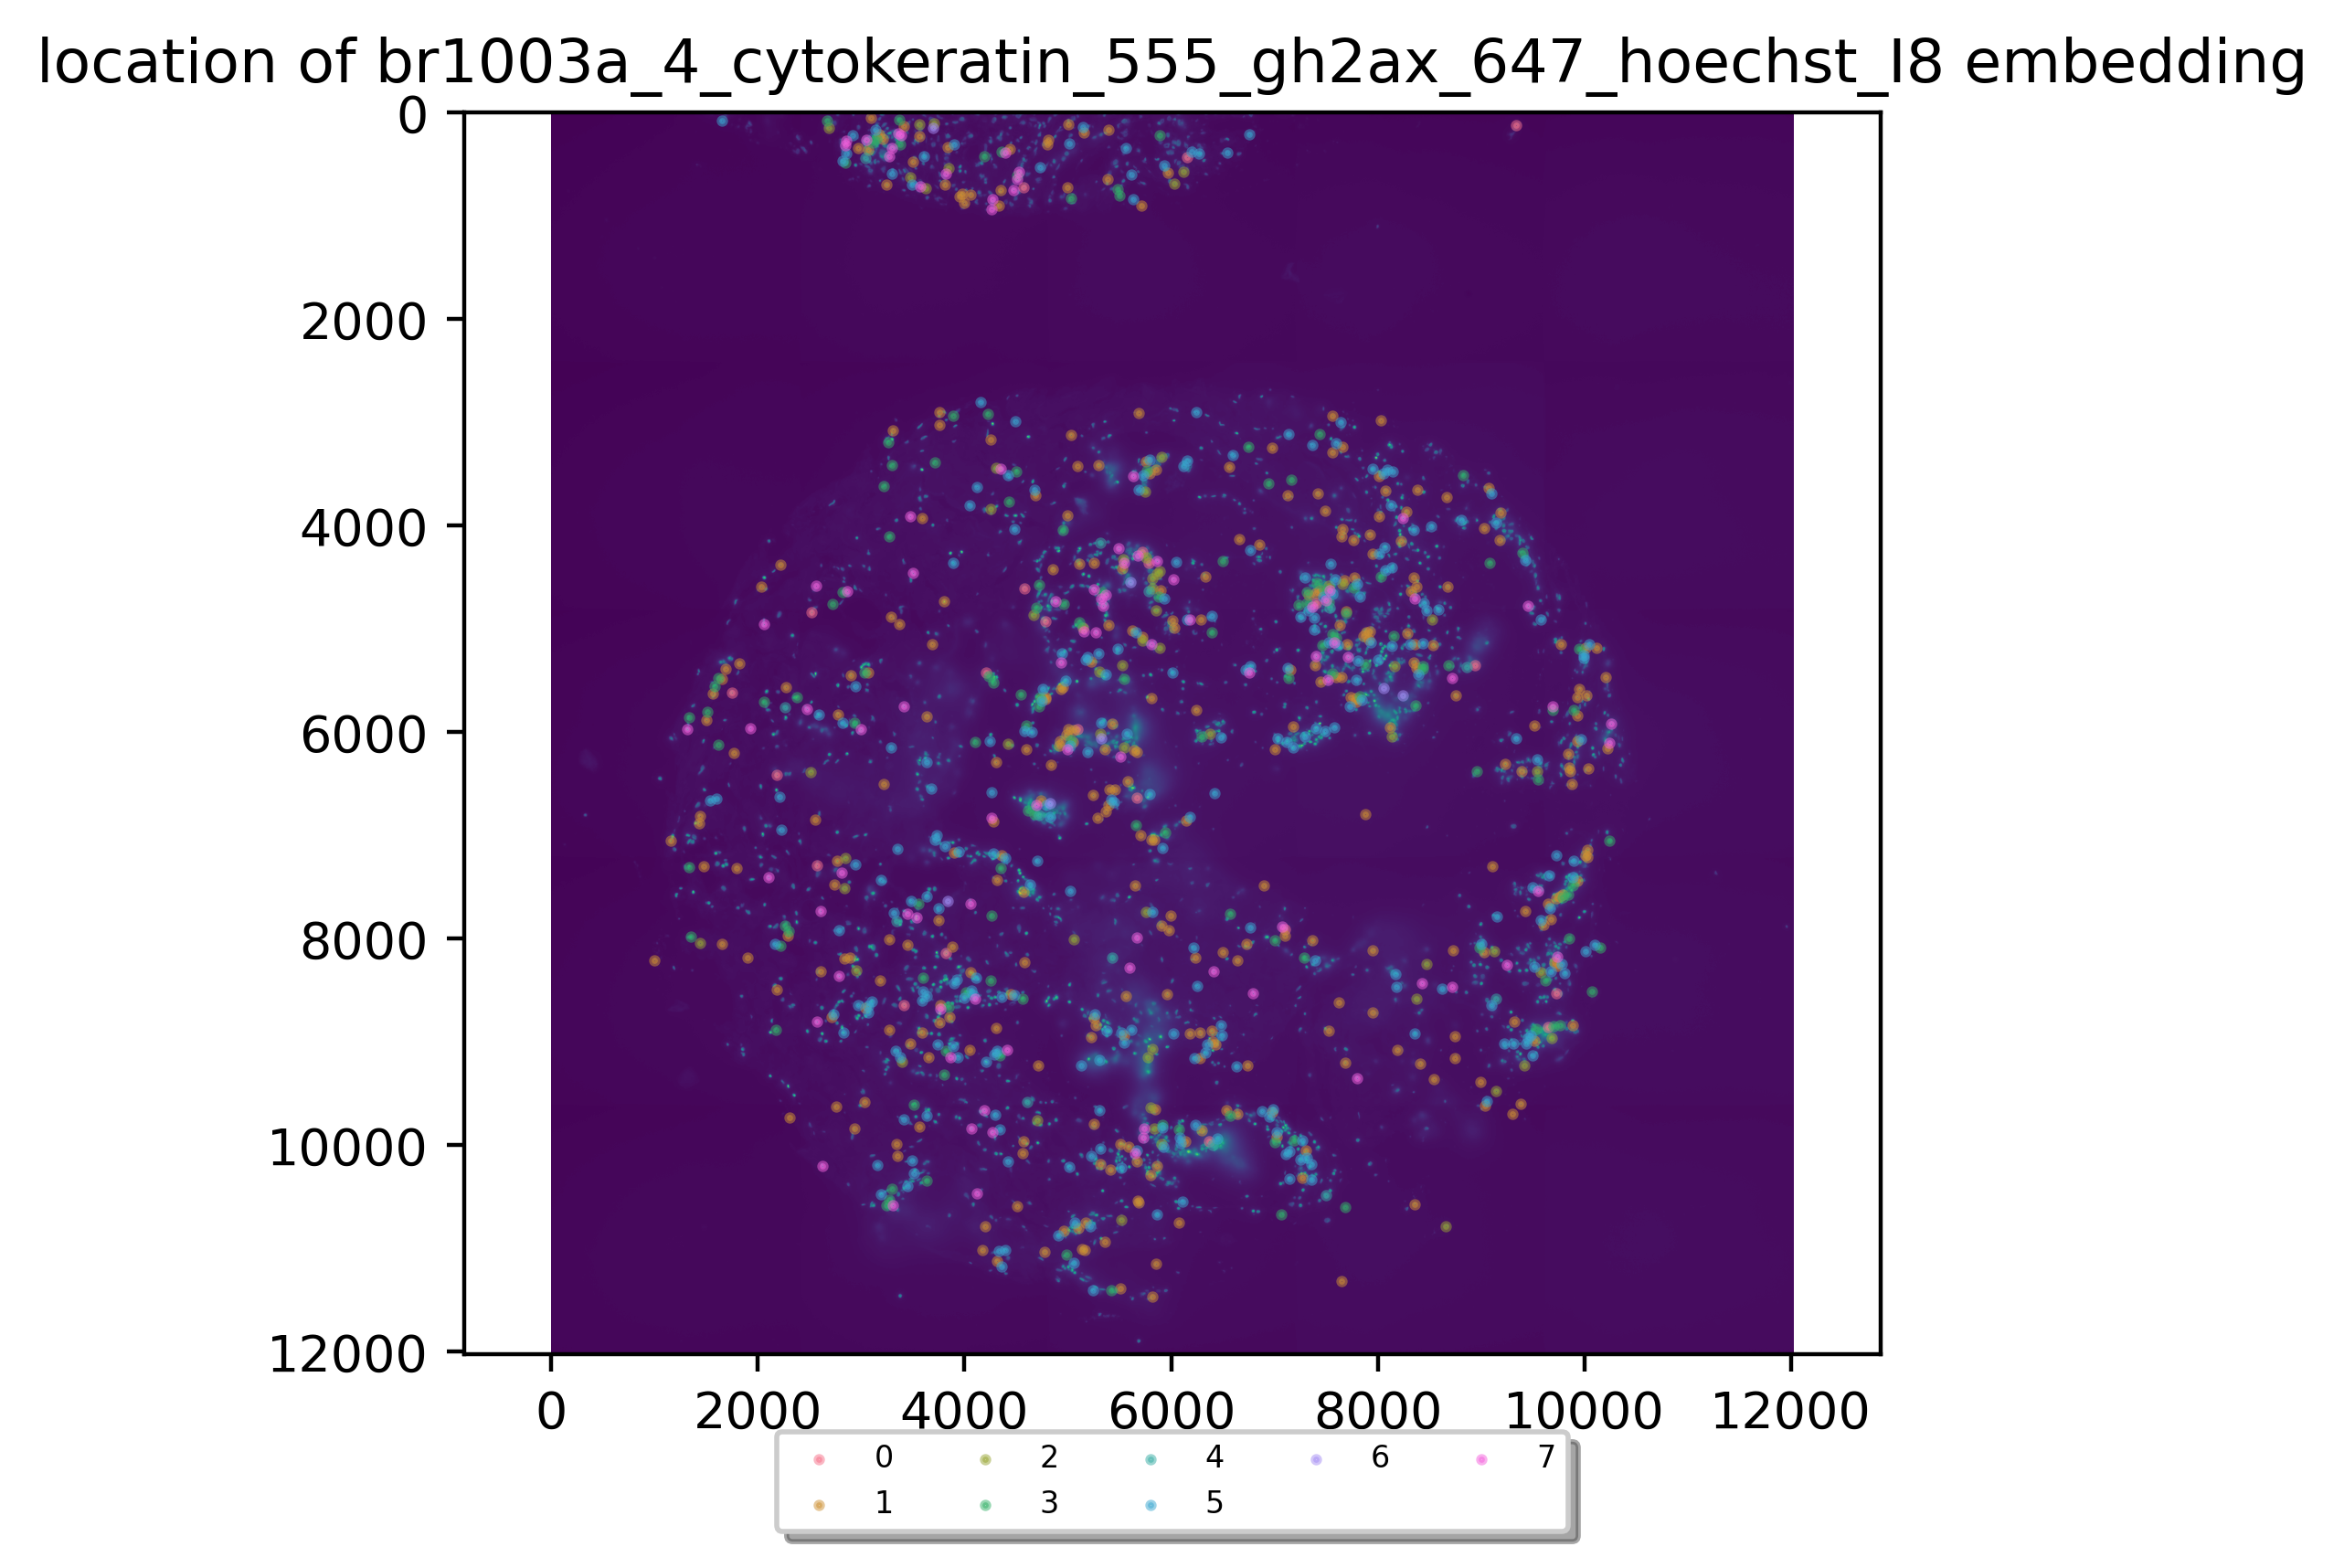

In [52]:
#plot only -- TODO: plot on full samples instead
np.random.seed(6)
# plotPCT=4500
plottingIdx_i=np.array([])
n_pcs=50
uniqueImgNames,imgNameIdx=np.unique(allImgNames,return_index=True)
for i in range(1):
    for sidx in range(uniqueImgNames.size):
        s=uniqueImgNames[sidx]
        p=progList[imgNameIdx[sidx]]
        print(s+' '+p)
        nsamples=int(np.sum(allImgNames==s)*progSampleRate[p])
        plottingIdx_i=np.concatenate((plottingIdx_i,
                                    np.random.choice(np.arange(allImgNames.shape[0])[allImgNames==s],nsamples,replace=False)))

#     clusterMinibatchKmean_allsample(savedir,clustersavedir,latent[plottingIdx_i.astype(int)],[4,8,12],n_pcs,coordlist[plottingIdx_i.astype(int)],allImgNames[plottingIdx_i.astype(int)],'_plottingIdx_'+str(plotPCT)+'_'+str(i))
    clusterMinibatchKmean_allsample(savedir,clustersavedir,None,[8,20,25],n_pcs,coordlist[plottingIdx_i.astype(int)],allImgNames[plottingIdx_i.astype(int)],'_plottingIdx_progBalanced_'+str(i),plotOnly=True,plotUpdate=False)

In [ ]:
# ##TODO: for kmeans as well: fit on subset but plot all data (save model)

# np.random.seed(6)
# plotPCT=4500
# plottingIdx_i=np.array([])
# n_pcs=50
# for i in range(1):
#     for s in np.unique(allImgNames):
#         nsamples=min(int(np.sum(allImgNames==s)),plotPCT)
#         plottingIdx_i=np.concatenate((plottingIdx_i,
#                                     np.random.choice(np.arange(allImgNames.shape[0])[allImgNames==s],nsamples,replace=False)))
#     clusteragg_allsample('euclidean',['ward', 'complete', 'average', 'single'],savedir,clustersavedir,latent[plottingIdx_i.astype(int)],[4,8,12,16],n_pcs,coordlist[plottingIdx_i.astype(int)],allImgNames[plottingIdx_i.astype(int)],'_plottingIdx_'+str(plotPCT)+'_'+str(i))
#     gc.collect()

#### more umap of each cluster and subcluster

In [17]:
np.random.seed(6)
# plotPCT=4500
plottingIdx_i=np.array([])
n_pcs=50
uniqueImgNames,imgNameIdx=np.unique(allImgNames,return_index=True)
for i in range(1):
    for sidx in range(uniqueImgNames.size):
        s=uniqueImgNames[sidx]
        p=progList[imgNameIdx[sidx]]
        print(s+' '+p)
        nsamples=int(np.sum(allImgNames==s)*progSampleRate[p])
        plottingIdx_i=np.concatenate((plottingIdx_i,
                                    np.random.choice(np.arange(allImgNames.shape[0])[allImgNames==s],nsamples,replace=False)))



br1003a_1_cytokeratin_555_aSMA_647_hoechst_A1 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A2 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A4 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A5 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A6 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A7 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A8 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A9 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C1 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C10 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C2 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C3 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C4 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C5 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C6 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C7 Hyperplasia
br1003a_1_cytokeratin_555_

br301_6_collagen1_647_hoechst_D2 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_D3 Invasive ductal carcinoma and breast tissue
br301_6_collagen1_647_hoechst_D4 Invasive ductal carcinoma
br301_6_collagen1_647_hoechst_D5 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_D6 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E1 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E2 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E3 Invasive ductal carcinoma and breast tissue
br301_6_collagen1_647_hoechst_E4 Invasive ductal carcinoma
br301_6_collagen1_647_hoechst_E5 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E6 Ductal carcinoma in situ with early infiltratio
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A1 Invasive ductal carcinoma
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A10 Invasive ductal carcinoma
br8018a_1_cytoke

In [ ]:
#subcluster (25 incomplete)
# nclusterL=[8,12,20,25]
nclusterL=[25]
subclusterL=[2,3,4,6,8,10,12,15,20]
for ncluster in nclusterL:
    i=0
    savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(ep)+'_plottingIdx_progBalanced_'+str(i)
    with open(os.path.join(clustersavedir,savenamecluster), 'rb') as output:
        clusterRes=pickle.load(output)
    for c in np.unique(clusterRes):
        if int(c)<12:
            continue
        print(c)
        subclustersavedir=os.path.join(clustersavedir,savenamecluster+'_subcluster'+str(c))
        subclusterplotdir=os.path.join(subclustersavedir,'plots')
        if not os.path.exists(subclustersavedir):
            os.mkdir(subclustersavedir)
        if not os.path.exists(subclusterplotdir):
            os.mkdir(subclusterplotdir)
        clusterMinibatchKmean_allsample(subclusterplotdir,subclustersavedir,latent[plottingIdx_i.astype(int)][clusterRes==c],subclusterL,n_pcs,coordlist[plottingIdx_i.astype(int)][clusterRes==c],allImgNames[plottingIdx_i.astype(int)][clusterRes==c],'_plottingIdx_progBalanced_'+str(i),clusterOnly=True,embeddingSub=embedding[clusterRes==c])
        gc.collect()

In [35]:
gc.collect()

736557

In [37]:
# nclusterL=[8,12,20]
for ncluster in nclusterL:
    if ncluster==25:
        continue
    savenamecluster0='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(ep)+plotsavenameAdd
    with open(os.path.join(clustersavedir,savenamecluster0), 'rb') as output:
        clusterRes=pickle.load(output)
    for c in np.unique(clusterRes):
        reduceri = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed).fit(latent[plottingIdx_i.astype(int)][clusterRes==c])
        savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(ep)+'_cluster'+str(c)
        with open(os.path.join(modelsavepath,'umap'+plotsavenameAdd+savenameAdd), 'wb') as output:
            pickle.dump(reduceri, output, pickle.HIGHEST_PROTOCOL)
        subclustersavedir=os.path.join(clustersavedir,savenamecluster0+'_subcluster'+str(c))
        subclusterplotdir=os.path.join(subclustersavedir,'plots')    
        plotembeddingbyCT_str(progList[plottingIdx_i.astype(int)][clusterRes==c],'prog_umaptrain'+plotsavenameAdd,[],reduceri.embedding_,subclusterplotdir,plottype+' of all samples',plotdimx=dim1,plotdimy=dim2,savenameAdd=savenameAdd+'_pc'+str(dim1)+'pc'+str(dim2))
        plotembeddingbyCT_contrast(progList[plottingIdx_i.astype(int)][clusterRes==c],'prog_umaptrain'+plotsavenameAdd,[],reduceri.embedding_,os.path.join(subclusterplotdir,'contrast'),plottype+' of all samples',plotdimx=dim1,plotdimy=dim2,savenameAdd=savenameAdd+'_pc'+str(dim1)+'pc'+str(dim2))
        
        for subcluster in subclusterL:
            savenamecluster='minibatchkmean_ncluster'+str(subcluster)+'n_pcs'+str(n_pcs)+'epoch'+str(ep)+plotsavenameAdd
            with open(os.path.join(subclustersavedir,savenamecluster), 'rb') as output:
                subclusterRes=pickle.load(output)
            plotembeddingbyCT(subclusterRes,'prog_umaptrain'+plotsavenameAdd+'_ncluster'+str(subcluster),[],reduceri.embedding_,subclusterplotdir,plottype+' of all samples',plotdimx=dim1,plotdimy=dim2,savenameAdd=savenameAdd+'_pc'+str(dim1)+'pc'+str(dim2))
            plotembeddingbyCT_contrast(subclusterRes,'prog_umaptrain'+plotsavenameAdd+'_ncluster'+str(subcluster),[],reduceri.embedding_,os.path.join(subclusterplotdir,'contrast'),plottype+' of all samples',plotdimx=dim1,plotdimy=dim2,savenameAdd=savenameAdd+'_pc'+str(dim1)+'pc'+str(dim2))
            gc.collect()

In [22]:
#plot examples
plotepoch=ep
subclusterL=[2,3,4,6,8,10,12,15,20]
ncells=20
plotsavenameAdd='_plottingIdx_progBalanced_'+str(0)

nclusterL=[8,12,20,25]
for ncluster in nclusterL:
    if ncluster==25:
        continue
    savenamecluster0='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+plotsavenameAdd
    with open(os.path.join(clustersavedir,savenamecluster0), 'rb') as output:
        clusterRes=pickle.load(output)
    for c in np.unique(clusterRes):
        subclustersavedir=os.path.join(clustersavedir,savenamecluster0+'_subcluster'+str(c))
        subclusterplotdir=os.path.join(subclustersavedir,'plots') 
        
        for subcluster in subclusterL:
            savenamecluster='minibatchkmean_ncluster'+str(subcluster)+'n_pcs'+str(n_pcs)+'epoch'+str(ep)+plotsavenameAdd
            with open(os.path.join(subclustersavedir,savenamecluster), 'rb') as output:
                subclusterRes=pickle.load(output)
            progs=np.unique(progList[plottingIdx_i.astype(int)][clusterRes==c])
            for p in range(progs.size):
                img_p=allImg[plottingIdx_i.astype(int)][clusterRes==c][progList[plottingIdx_i.astype(int)][clusterRes==c]==progs[p]]
                cluster_p=subclusterRes[progList[plottingIdx_i.astype(int)][clusterRes==c]==progs[p]]
                plotExample=np.zeros((np.unique(cluster_p).size*(radius+1)*2,ncells*(radius+1)*2))
                for csub in range(np.unique(cluster_p).size):
                    clusteridx=np.arange(img_p.shape[0])[cluster_p==np.unique(cluster_p)[csub]]
                    np.random.seed(6)
                    cp_plot=np.random.choice(clusteridx,min(ncells,clusteridx.size),replace=False)
                    for cp_i in range(cp_plot.size):
                        plotExample[csub*(radius*2+2):csub*(radius*2+2)+radius*2,cp_i*(radius*2+2):cp_i*(radius*2+2)+radius*2]=img_p[cp_plot[cp_i]]
                fig, ax = plt.subplots(figsize=(20,20))
                img = ax.imshow(plotExample)
                ax.set_yticks(np.arange(np.unique(cluster_p).size).astype(int)*(radius*2+2)+(radius+1))
                ax.set_yticklabels(np.unique(cluster_p))
                fig.tight_layout()
                plt.savefig(os.path.join(subclusterplotdir,'plotexamples'+progs[p]+str(subcluster)+'.jpg'))
                plt.close()
                gc.collect()